In [ ]:
# COLAB ONLY
import os
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
!unlink "/content/coopmotion"
!ln -s "/gdrive/My Drive/coopmotion/" "/content/coopmotion"
!rm -r "/content/coopmotion/dataset (1)" "/content/coopmotion/dataset" "/content/coopmotion/models"

In [576]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
sys.path.append('coopmotion/src')
from matplotlib import pyplot as plt
import numpy as np
np.printoptions(precision=3, suppress=True);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Task

There are N agents in a 2D world $[[0, L],[0, L]]$ [Default L is 1];
initial position is random (but ordered); find a controller to reach a given target position

## Target points

The target points $x_T,y_T$ may be evently spaced every 360/n degrees on the L/2 radius circle

In [758]:
from task.square import *
from task.fancy import plot_task

#### Standard task

With N=4 the targets will always have a 90 degrees, starting from 0.
The coordinate format is always (N,2)

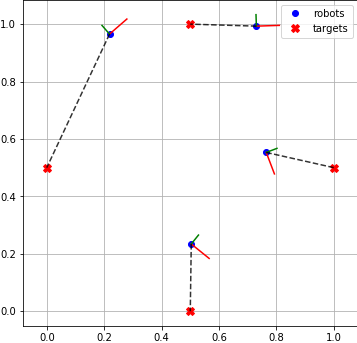

Targets
 [[1.  0.5]
 [0.5 1. ]
 [0.  0.5]
 [0.5 0. ]]
Original matrix form
 [[[ 0.35579712  0.93456322  0.76469637]
  [-0.93456322  0.35579712  0.55302156]
  [ 0.          0.          1.        ]]

 [[ 0.99946547 -0.03269204  0.73029382]
  [ 0.03269204  0.99946547  0.99303008]
  [ 0.          0.          1.        ]]

 [[ 0.75524942 -0.6554375   0.21867566]
  [ 0.6554375   0.75524942  0.96534703]
  [ 0.          0.          1.        ]]

 [[ 0.77817391  0.62804885  0.50344098]
  [-0.62804885  0.77817391  0.23403805]
  [ 0.          0.          1.        ]]]
Extracted angles in degrees
 [-69.15769391   1.87344994  40.9528321  -38.90631677]
Extracted data (x,y,theta)
 [[ 0.76469637  0.55302156 -1.20702946]
 [ 0.73029382  0.99303008  0.03269787]
 [ 0.21867566  0.96534703  0.71476176]
 [ 0.50344098  0.23403805 -0.67904333]]
Extracted data (x,y,theta), another method
 [[[ 0.76469637  0.55302156 -1.20702946]
  [ 0.73029382  0.99303008  0.03269787]
  [ 0.21867566  0.96534703  0.71476176]
  [ 

In [634]:
task = static_evenly_spread_task(N=4)
pos_state = task.initialize()
plot_task(pos_state,task.targets)
print("Targets\n", task.targets)
print("Original matrix form\n", pos_state)
print("Extracted angles in degrees\n", extract_thetas_from_state(pos_state)*180/np.pi)
print("Extracted data (x,y,theta)\n", extract_from_state(pos_state))
print("Extracted data (x,y,theta), another method\n",extract_from_trace(np.array([pos_state])))

#### Enhanced task

The targets are the result of the hungarian assigment problem and the ICP algorithm, in order to minimize the travelling distance (therefore only the radius is unchanged)

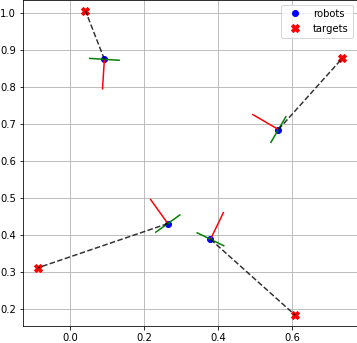

Targets
 [[ 0.60828796  0.18294422]
 [-0.08711149  0.31108324]
 [ 0.73642698  0.87834367]
 [ 0.04102753  1.00648269]]
Targets mean [0.32465775 0.59471345]


In [585]:
task = smart_static_evenly_spread_task(N=4)
plot_task(task.initialize(),task.targets)
print("Targets\n", task.targets)
print("Targets mean", task.targets.mean(0))

Importat to notice here that the barycenter of the targets slightly changes. This could affect the outcome of the training for centralized and distributed network.

There is also another interesting asymmetric configuration: Zipf $L - L/2, L - L/3, L - L/4, \ldots$
As you can see, in the following scenario, the robots would have to spend most of their time travelling through the most part of map.

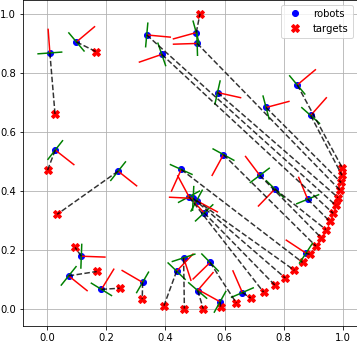

In [586]:
task = static_zipf_task(N=32)
pos_state = task.initialize()
initial,targets = pos_state.copy(), task.targets.copy()
plot_task(initial,targets)

In more complex configurations, ICP becomes incredibily useful. All the task with the 'smart' suffix makes this calculation once at the start, right after the initial configuration is randomly generated

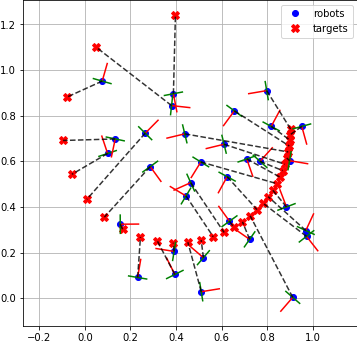

In [587]:
task = smart_static_zipf_task(N=32)
plot_task(task.initialize(),task.targets)

#### What happens behind the scenes
4 iterations of ICP has proven to be enough in most (if not all) cases. The final result (scroll down) shows how the first zipf plot would have looked like if it was not 'static'

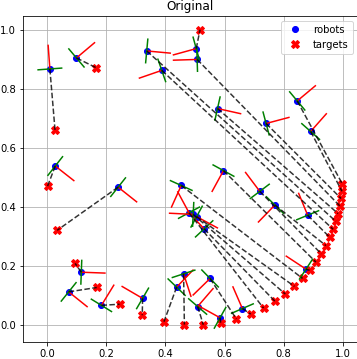

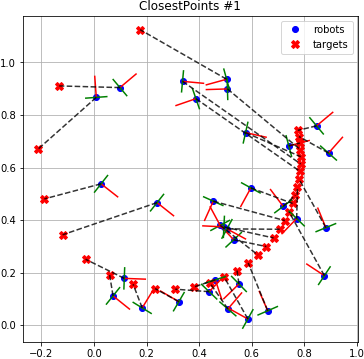

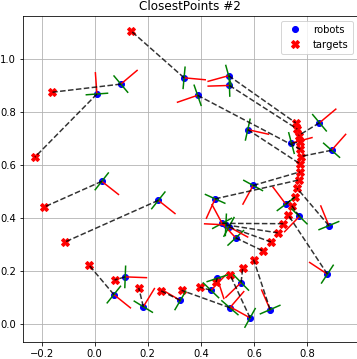

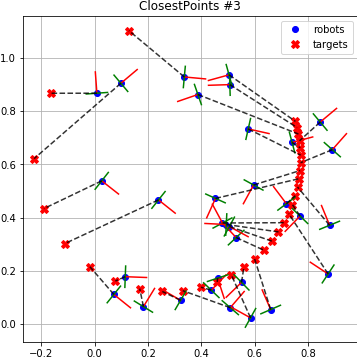

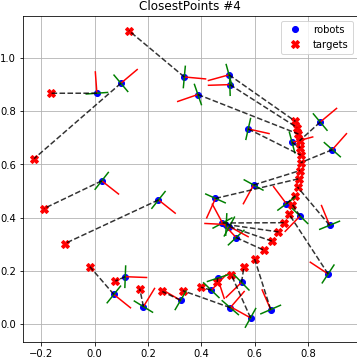

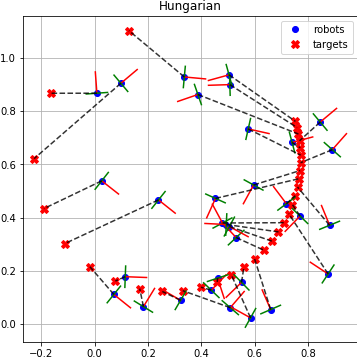

In [588]:
hungarian_ICP(initial, targets, 4, show=True);

## Controllers

The multi-agent omniscent PID controller $c$ feed the exact position state of each agent to a controller to compute the linear and the angular velocities (output). We assume an absolute maximal linear speed of $v_\max=0.5$ and for the angular $v_\max=\pi$

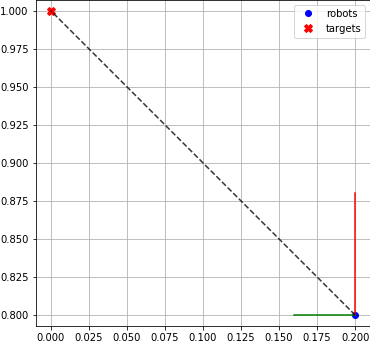

The robot at [0.2, 0.8] needs to go to [0, 1]
His linear velocity controller says: 0.282842712474619
His angular velocity controller says: 0.7853981633974487


In [761]:
lc = proportional(tau=2.)
ac = proportional(tau=0.3)
task = smart_static_evenly_spread_task(N=4)
pose, target = mktr(0.2,0.8) @ mkrot(np.pi/2), [0,1]
plot_task(np.array([pose]),np.array([target]))
xy, theta = extract_tuple_from_mat(pose)
print(f"The robot at {xy} needs to go to {target}")
lc_out = controller(euclidean_distance(xy, target))
print(f"His linear velocity controller says: {lc_out}")
ac_out = controller(angle_difference(steering_angle(xy, target), theta))
print(f"His angular velocity controller says: {ac_out}")

## Sensing

The compass-equipped agents can sense the xy-distance to the n-nearest neigbors. (WALL?)

In [590]:
task = smart_static_evenly_spread_task(N=4)

#### Sensing the relative position of the robot in range
The absolute poses are converted to the sensing robot's point of view. In a way, we still are working with deltas, but now it's because the other robots are in the frame of the observing robot, which is always at 'his' (0,0).

[[[ 0.18744059 -0.41684459  0.50307679]
  [ 0.16884881 -0.63743897  0.33222698]
  [ 0.40521637 -0.22798579  0.49146997]]

 [[-0.25304853  0.38060455  1.28802982]
  [ 0.01771177 -0.22066679  0.91761891]
  [ 0.18398073  0.22191221  0.95048843]]

 [[ 0.6427948   0.14715028  1.23293466]
  [ 0.21983765 -0.02605661  1.03337356]
  [ 0.40120798 -0.25010736  0.93815196]]

 [[ 0.28403324 -0.36810725  1.2923522 ]
  [ 0.27422997  0.08883616  0.96641763]
  [ 0.37747798  0.28466105  0.83832651]]]


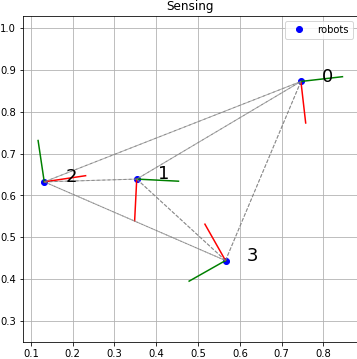

In [727]:
from task.fancy import plot_sensing
pos_state = task.initialize()
#pos_state = np.array([mktr(x,y) for x, y in [(0,0),(1,0),(0,1),(1,1)]])
sensing = sense_all()(pos_state)
print(sensing)
plot_sensing(pos_state, sensing)

## Run
During one run, at time step $\Delta t$, each agent applies the central controller output to update its position. We stop the run after T seconds or after each agent reaches the target point, i.e. $|x - x_T| < \epsilon$. For the bang-bang controller to converge,  $\epsilon > \frac{\Delta t v_\max}{2}$.

In [713]:
from task.square import SegmentRun
from task.fancy import plot_trace
from task import Trace
run = SegmentRun(task, proportional, sensor=sense_in_range(0.8), dt=0.1)
trace = run(epsilon=0.01, T=10)

that contains

In [714]:
trace._field_types

OrderedDict([('time', numpy.ndarray),
             ('pos_state', numpy.ndarray),
             ('communication', numpy.ndarray),
             ('sensing', numpy.ndarray),
             ('control', numpy.ndarray),
             ('targets', numpy.ndarray),
             ('error', numpy.ndarray)])

Saved in images/trace/s=all-_t=SmartStaticPositionTask.png


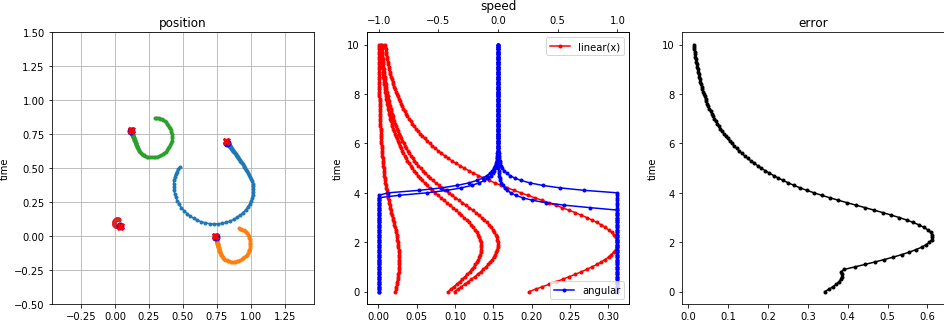

In [768]:
from task.square import SegmentRun
from task.fancy import animate_with_targets, plot_trace
run = SegmentRun(smart_static_evenly_spread_task(4), proportional, sensor=sense_all(), dt=0.1)
trace = run(epsilon=0.005, T=10)
plot_trace(trace, run.task, context=globals())

In [769]:
animate_with_targets(trace, run.sensor, dt=0.1, context=globals())

Saved in videos/s=all-_t=SmartStaticPositionTask.mp4


## Datasets

Running multiple times, we generate datasets. 
For non sequential datasets, we run for one step from a random intial configuration and return a concatenated `Trace`.
Sequential dataset are istead run for a finite time `T` (and/or upto convergence to `epsilon`) and are returned as `List[Trace]`

In [720]:
def hist3d(trace, n_robots, bins, height, title):
    import plotly.graph_objects as go
    import colorlover as cl
    ryb = cl.scales['11']['qual']['Paired']

    fig = go.Figure()
    fig.update_layout(title=go.layout.Title(
        text=title,
        xref="paper",
        x=0
    ), scene = dict(
                        xaxis = dict(nticks=4, range=[0,1],),
                        yaxis = dict(nticks=4, range=[0,1],),
                             zaxis = dict(nticks=4, range=[0,height],),),
                             width=700,
                             margin=dict(r=20, l=10, b=10, t=10))
    for ix, xy in enumerate(np.moveaxis(trace,0,-1)):
        hist, xedges, yedges = np.histogram2d(xy[0,:], xy[1,:], bins=bins)
        xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")

        xpos = xpos.ravel()
        ypos = ypos.ravel()
        dz = hist.ravel()

        fig.add_trace(go.Mesh3d(x=xpos,y=ypos,z=dz,
                           #opacity=0.3,
                           color=ryb[ix]))
    fig.show()

#### Static task (without ICP)
Some clear indipendent behaviour is visually expected from each robot

In [721]:
from task.square import SegmentRun
from task.dataset import generate_non_sequential_dataset, generate_sequential_dataset
n_runs = 100
n_robots = 4
run = SegmentRun(static_evenly_spread_task(n_robots), proportional, sensor=sense_in_range(0.8))
trace = generate_non_sequential_dataset(run, n_runs)

100%|██████████| 100/100 [00:03<00:00, 29.05it/s]


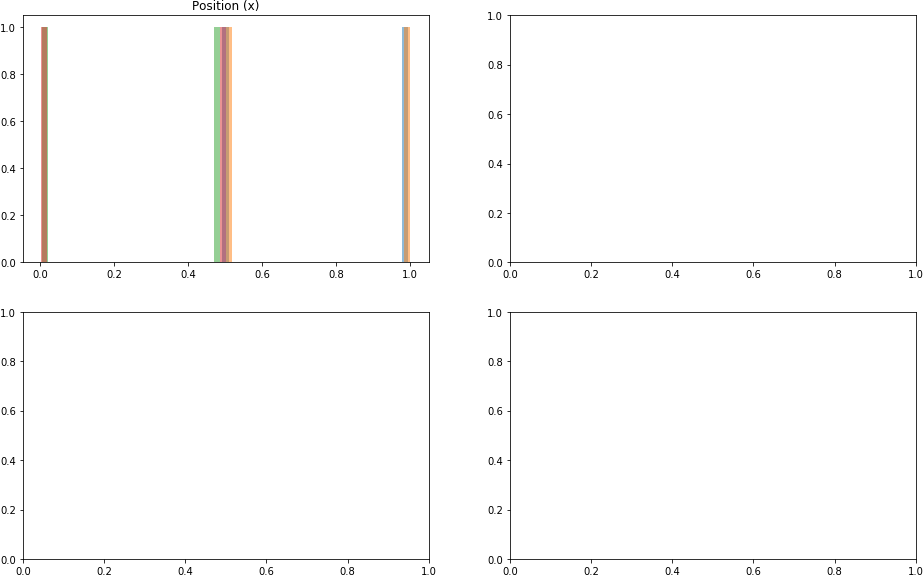

In [726]:
fig, axs = plt.subplots(2,2, figsize=(16,10))
axs[0,0].set_title('Position (x)')
for state in np.moveaxis(trace.pos_state,0,-1):
    state = extract_xys_from_state(np.moveaxis(state,-1,0))
    axs[0,0].hist(state[0,:], bins=30, alpha=0.5);
# axs[0,1].set_title('Sensing (closest robot dx)')
# for sensing in np.moveaxis(trace.sensing,0,-1):
#     axs[0,1].hist(sensing[0,0,:], bins=30, alpha=0.5);
# axs[1,0].set_title('Control (vx)')
# for control in np.moveaxis(trace.control,0,-1):
#     axs[1,0].hist(control[0,:], bins=30, alpha=0.5);
# axs[1,1].set_title('Error')
# axs[1,1].hist(trace.error, bins=60, alpha=0.5);
# plt.savefig('static 2d')
#axs[1,1].set_title('Targets')
#for control in np.moveaxis(trace.targets,0,-1):
#   axs[1,1].hist(control[0,:], bins=30, alpha=0.5);

In [ ]:
hist3d(trace.state, n_robots, 50, 4000, 'Positions (static task)')

### Smart task (ICP)
ICP may be key for distributed training, but we lose the notion of specific subtask for each robot. Therefore, asymmetric target shapes like zipf absolutely bring the need of some other information in training, for example communication vectors.

In [ ]:
from task.square import SegmentRun
from task.dataset import generate_non_sequential_dataset, generate_sequential_dataset
n_runs = 1000
run = SegmentRun(smart_static_evenly_spread_task(n_robots), proportional, sensor=sense_sorted_all())
trace = generate_non_sequential_dataset(run, n_runs)

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(16,10))
axs[0,0].set_title('Position (x)')
for state in np.moveaxis(trace.state,0,-1):
    axs[0,0].hist(state[0,:], bins=30, alpha=0.5);
axs[0,1].set_title('Sensing (closest robot dx)')
for sensing in np.moveaxis(trace.sensing,0,-1):
    axs[0,1].hist(sensing[0,0,:], bins=30, alpha=0.5);
axs[1,0].set_title('Control (vx)')
for control in np.moveaxis(trace.control,0,-1):
    axs[1,0].hist(control[0,:], bins=30, alpha=0.5);
axs[1,1].set_title('Error')
axs[1,1].hist(trace.error, bins=60, alpha=0.5);
plt.savefig('smart 2d')
#axs[1,1].set_title('Targets')
#for control in np.moveaxis(trace.targets,0,-1):
#   axs[1,1].hist(control[0,:], bins=30, alpha=0.5);

In [ ]:
hist3d(trace.state, n_robots, 30, 200, 'Positions (ICP)')

Some other visualizations

In [ ]:
run = SegmentRun(static_evenly_spread_task(4), proportional, sensor=sense_in_range(0.25))
traces = generate_sequential_dataset(run, 100)

In [ ]:
for trace in traces[:200]:
    plt.plot(trace.state[:,:,0], trace.time, 'k', alpha=0.05)

In [ ]:
run = SegmentRun(static_evenly_spread_task(4), proportional,sensor=sense_in_range(0.25), dt=0.01)
traces = generate_sequential_dataset(run, 100, epsilon=0.01)

In [ ]:
for trace in traces[:200]:
    plt.plot(trace.state[:,:,0], trace.time, 'k', alpha=0.05)

In [ ]:
run = SegmentRun(smart_static_evenly_spread_task(4), bang_bang, sensor=sense_in_range(0.25), dt=0.005)
traces = generate_sequential_dataset(run, 100, name='', epsilon=0.01)
for trace in traces[:200]:
    plt.plot(trace.state[:,:,0], trace.time, 'k', alpha=0.05)